## 4.2 Learning Rate, Scheduler, and Batch Size Optimization

Building on the strong performance of the fully fine-tuned model, this section investigates whether additional improvements can be achieved by tuning key training hyperparameters: **initial learning rate**, **learning rate scheduler**, and **batch size**. These three elements are critical to training dynamics, impacting convergence speed, stability, and generalization.

Because of their interdependence, these parameters are evaluated jointly in a coordinated 3-dimensional grid search:

- **Learning Rate (LR):** Determines the step size for parameter updates. A rate too high can lead to divergence; too low can result in slow or suboptimal convergence.
- **Scheduler:** Governs how the learning rate changes over time. Decay strategies like linear or cosine—with or without warm-up—help the model avoid overshooting and settle into flatter minima.
- **Batch Size:** Affects gradient variance and memory usage. Smaller batches introduce noise that can enhance generalization; larger batches provide smoother gradients but may risk overfitting or poor minima.

The grid search spans:
- **4 learning rates**
- **2 scheduler types**
- **3 batch sizes**

This produces **24 unique training runs**, each over **2 epochs**, totaling 48 effective epochs of training.

To keep the main notebook focused and manageable, this sweep is performed in a companion notebook:

 **[Hyperparameter Grid Search](./part1_experiments/4.1_lr_scheduler_batchsize_gridsearch.ipynb)**  






# Imports

In [5]:
!pip install transformers scikit-learn pandas numpy tqdm tensorflow
!pip install -q datasets

import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, create_optimizer, DefaultDataCollator, AutoTokenizer
from datasets import load_dataset # Hugging Face
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


import warnings
warnings.filterwarnings("ignore")

# Load Tokenized Dataset

In [6]:
# Load the "all agree" subset
dataset = load_dataset("financial_phrasebank", "sentences_allagree") # All agree signifies 100% of annotators agreed on sentiment of this subset

# Peek at the data
dataset["train"][0]
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


# Re-Run Model
- This is done to avoid cross referencing across notebooks. Weight configurations might be slightly off between versions, but this should not impact the resulting conclusions of grid search because _



Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 20s 76ms/step - loss: 0.5624 - accuracy: 0.7108 - val_loss: 1.8277 - val_accuracy: 0.8009
Epoch 2/3
114/114 [==============================] - 7s 62ms/step - loss: 0.4111 - accuracy: 0.8261 - val_loss: 0.0017 - val_accuracy: 0.8319
Epoch 3/3
15/15 [==============================] - 2s 45ms/step

Test Accuracy: 0.8634
              precision    recall  f1-score   support

    Negative       0.88      0.47      0.61        30
     Neutral       0.94      0.96      0.95       142
    Positive       0.69      0.84      0.75        55

    accuracy                           0.86       227
   macro avg       0.84      0.75      0.77       227
weighted avg       0.87      0.86      0.86       227



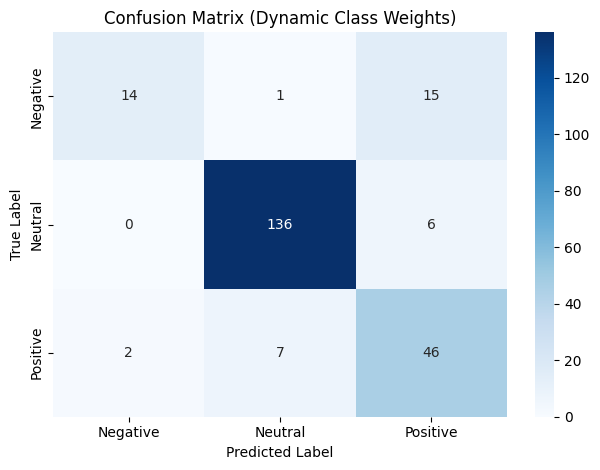

In [7]:
# Assign token length and bins
def compute_length_and_bin(example):
    length = len(tokenizer.tokenize(example["sentence"]))
    example["token_length"] = length
    return example

dataset = dataset.map(compute_length_and_bin)

# Compute quantiles and bin edges from training set
lengths = dataset["train"]["token_length"]
q1, q2 = np.percentile(lengths, [33, 66])

def assign_bin(example):
    length = example["token_length"]
    if length <= q1:
        example["bin_index"] = 0  # short
    elif length <= q2:
        example["bin_index"] = 1  # medium
    else:
        example["bin_index"] = 2  # long
    return example

dataset = dataset.map(assign_bin)

# Tokenization
def tokenize_with_bin(example):
    tokens = tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=256)
    tokens["label"] = example["label"]
    tokens["bin_index"] = example["bin_index"]
    return tokens

tokenized_datasets = dataset.map(tokenize_with_bin, batched=True)

# Split train/val/test
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split["test"].train_test_split(test_size=0.5, seed=42)

# Prepare weight matrix [3 bins × 3 classes]
bin_class_counts = defaultdict(Counter)
for i in range(len(train_val_split["train"])):
    row = train_val_split["train"][i]
    bin_class_counts[row["bin_index"]][row["label"]] += 1

weight_matrix = np.zeros((3, 3))
for bin_id, class_counts in bin_class_counts.items():
    total = sum(class_counts.values())
    for cls, count in class_counts.items():
        weight_matrix[bin_id][cls] = total / (len(class_counts) * count)

weight_tensor = tf.constant(weight_matrix, dtype=tf.float32)

# TF Dataset
def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask", "bin_index"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=16,
        collate_fn=None
    )

tf_train = to_tf_dataset(train_val_split["train"], shuffle=True)
tf_val = to_tf_dataset(val_test_split["train"], shuffle=True)
tf_test = to_tf_dataset(val_test_split["test"], shuffle=False)

# Custom model with dynamic loss (custom training wrapper)
class CustomDistilBERT(tf.keras.Model):
    def __init__(self, base_model, weight_tensor):
        super().__init__()
        self.model = base_model
        self.weight_tensor = weight_tensor
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, batch):
        x, y_true = batch
        bin_index = x["bin_index"]
        x = {k: v for k, v in x.items() if k != "bin_index"}

        with tf.GradientTape() as tape:
            logits = self.model(x, training=True).logits
            weights = tf.gather_nd(
                self.weight_tensor,
                tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
            )
            loss = self.loss_fn(y_true, logits)
            weighted_loss = tf.reduce_mean(loss * weights)

        grads = tape.gradient(weighted_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}


    def test_step(self, batch):
        x, y_true = batch
        bin_index = x["bin_index"]
        x = {k: v for k, v in x.items() if k != "bin_index"}

        logits = self.model(x, training=False).logits
        weights = tf.gather_nd(
            self.weight_tensor,
            tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
        )
        loss = self.loss_fn(y_true, logits)
        weighted_loss = tf.reduce_mean(loss * weights)
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}


    def call(self, inputs):
        filtered_inputs = {k: v for k, v in inputs.items() if k != "bin_index"}
        return self.model(filtered_inputs).logits


# Instantiate and train model
base_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
base_model.distilbert.trainable = False

model = CustomDistilBERT(base_model, weight_tensor)
model.compile(optimizer=tf.keras.optimizers.Adam())

history = model.fit(tf_train, validation_data=tf_val, epochs=3)

# Evaluation
logits = model.predict(tf_test)
y_pred = np.argmax(logits, axis=1)
y_true = np.concatenate([y for _, y in tf_test], axis=0)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix (Dynamic Class Weights)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()



# Save Weights, Unfreeze Encoder, Run Model

In [8]:
model.save_weights("distilbert_classifierhead_frozenencoder_bestweights.weights.h5")


In [9]:
# 1. Load the same architecture
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

# load the layers I trained before, and don’t error if you don’t find some new layers.
model.load_weights("distilbert_classifierhead_frozenencoder_bestweights.weights.h5", by_name=True, skip_mismatch=True)

# 3. Unfreeze all layers
model.trainable = True

# 4. Compile
initial_learning_rate = 2e-5
steps_per_epoch = len(tf_train)
num_train_steps = steps_per_epoch * 3
num_warmup_steps = int(0.1 * num_train_steps)

optimizer, lr_schedule = create_optimizer(
    init_lr=initial_learning_rate,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_59 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/3
114/114 [==============================] - 39s 179ms/step - loss: 0.5286 - accuracy: 0.6617 - val_loss: 0.1287 - val_accuracy: 0.9292
Epoch 2/3
114/114 [==============================] - 19s 162ms/step - loss: 0.1109 - accuracy: 0.9725 - val_loss: 0.0184 - val_accuracy: 0.9469
Epoch 3/3
15/15 [==============================] - 2s 45ms/step

Test Accuracy: 0.9427
              precision    recall  f1-score   support

    Negative       0.77      1.00      0.87        30
     Neutral       0.99      0.94      0.97       142
    Positive       0.94      0.91      0.93        55

    accuracy                           0.94       227
   macro avg       0.90      0.95      0.92       227
weighted avg       0.95      0.94      0.94       227



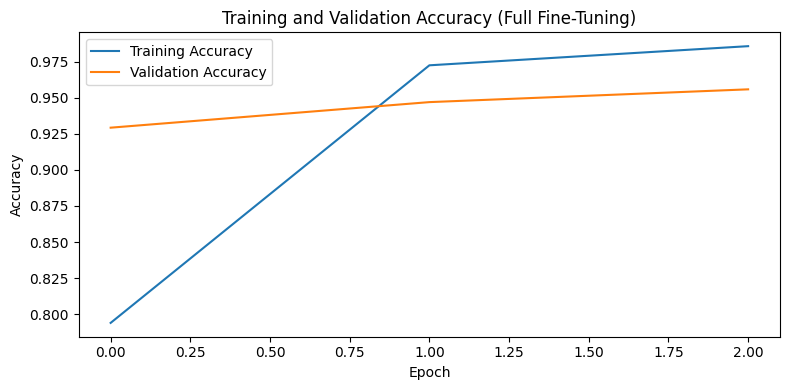

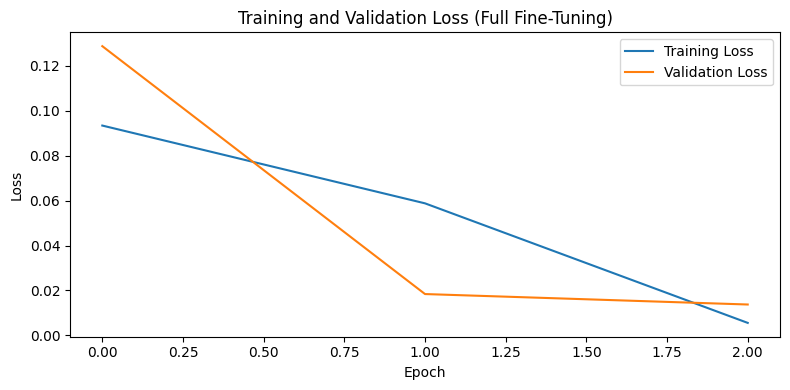

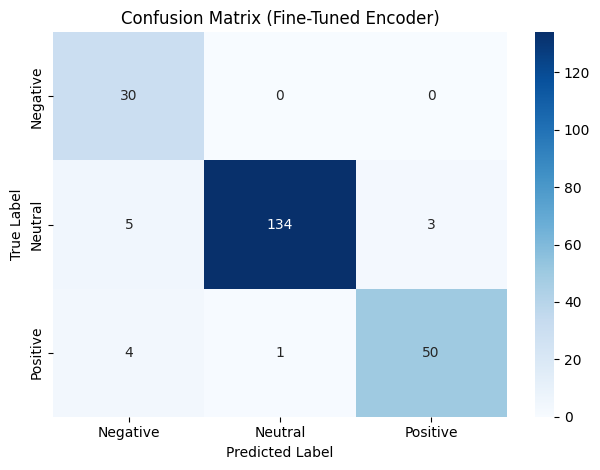

In [10]:
# === Rewrap model with dynamic bin-weighted loss ===
model = CustomDistilBERT(model, weight_tensor)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5))

# === Ensure data is split ===
try:
    train_val_split
    val_test_split
except NameError:
    print("train_val_split not found — regenerating splits...")
    train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
    val_test_split = train_val_split["test"].train_test_split(test_size=0.5, seed=42)

# === Create TF datasets (INCLUDES bin_index for dynamic loss) ===
def to_tf_dataset_with_bin(split, shuffle=False, batch_size=16):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask", "bin_index"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=batch_size,
        collate_fn=None
    )

tf_train = to_tf_dataset_with_bin(train_val_split["train"], shuffle=True)
tf_val = to_tf_dataset_with_bin(val_test_split["train"], shuffle=True)
tf_test = to_tf_dataset_with_bin(val_test_split["test"], shuffle=False)

# === Train ===
history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=3
)

# === Evaluate ===
logits = model.predict(tf_test)
y_pred = np.argmax(logits, axis=1)
y_true = np.concatenate([y for _, y in tf_test], axis=0)

# === Accuracy & Classification Report ===
print(f"\nTest Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# === Accuracy Plot ===
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Training and Validation Accuracy (Full Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# === Loss Plot ===
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss (Full Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix (Fine-Tuned Encoder)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


# Full 3-D Grid Search

Why I chose what

In [11]:
# Grid search space
learning_rates = [7e-5, 5e-5, 3e-5]
schedulers = ["polynomial", "cosine", "linear"]
batch_sizes = [8, 16, 32]
search_space = list(product(learning_rates, schedulers, batch_sizes))

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)
static_train = train_val_split['train']
static_val = val_test_split['train']

def to_tf_dataset(split, shuffle=False, batch_size=32):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=batch_size,
        collate_fn=DefaultDataCollator(return_tensors="tf")
    )

def load_fine_tuning_model():
    model = TFAutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=3
    )
    model.load_weights("distilbert_classifierhead_frozenencoder_bestweights.weights.h5", by_name=True, skip_mismatch=True)
    model.trainable = True
    return model

# Grid search
results = []

for lr, scheduler_name, batch_size in search_space:
    print(f"\nTraining with LR={lr}, Scheduler={scheduler_name}, Batch Size={batch_size}")

    tf_train_dataset = to_tf_dataset(static_train, shuffle=True, batch_size=batch_size)
    tf_val_dataset = to_tf_dataset(static_val, shuffle=False, batch_size=batch_size)

    steps_per_epoch = len(tf_train_dataset)
    total_steps = steps_per_epoch * 2
    warmup_steps = int(0.1 * total_steps)

    # Hugging Face-compatible optimizer with scheduler
    optimizer, _ = create_optimizer(
        init_lr=lr,
        num_train_steps=total_steps,
        num_warmup_steps=warmup_steps,
        weight_decay_rate=0.01
    )

    model = load_fine_tuning_model()
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    history = model.fit(
        tf_train_dataset,
        validation_data=tf_val_dataset,
        epochs=2,
        verbose=0
    )

    final_val_acc = history.history["val_accuracy"][-1]
    final_val_loss = history.history["val_loss"][-1]

    results.append({
        "lr": lr,
        "scheduler": scheduler_name,
        "batch_size": batch_size,
        "val_accuracy": final_val_acc,
        "val_loss": final_val_loss
    })

    print(f"→ Val Accuracy: {final_val_acc:.4f}, Val Loss: {final_val_loss:.4f}")

# Results table
results_df = pd.DataFrame(results).sort_values(by="val_accuracy", ascending=False).reset_index(drop=True)
display(results_df)




Training with LR=7e-05, Scheduler=polynomial, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.1659

Training with LR=7e-05, Scheduler=polynomial, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.1611

Training with LR=7e-05, Scheduler=polynomial, Batch Size=32


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9425, Val Loss: 0.1616

Training with LR=7e-05, Scheduler=cosine, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9336, Val Loss: 0.1756

Training with LR=7e-05, Scheduler=cosine, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.1743

Training with LR=7e-05, Scheduler=cosine, Batch Size=32


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9381, Val Loss: 0.1802

Training with LR=7e-05, Scheduler=linear, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9425, Val Loss: 0.1679

Training with LR=7e-05, Scheduler=linear, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9292, Val Loss: 0.2084

Training with LR=7e-05, Scheduler=linear, Batch Size=32


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.1835

Training with LR=5e-05, Scheduler=polynomial, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9425, Val Loss: 0.1907

Training with LR=5e-05, Scheduler=polynomial, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.1763

Training with LR=5e-05, Scheduler=polynomial, Batch Size=32


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.1763

Training with LR=5e-05, Scheduler=cosine, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9425, Val Loss: 0.1872

Training with LR=5e-05, Scheduler=cosine, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9558, Val Loss: 0.1292

Training with LR=5e-05, Scheduler=cosine, Batch Size=32


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9204, Val Loss: 0.2210

Training with LR=5e-05, Scheduler=linear, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9558, Val Loss: 0.1126

Training with LR=5e-05, Scheduler=linear, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.1902

Training with LR=5e-05, Scheduler=linear, Batch Size=32


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9425, Val Loss: 0.1826

Training with LR=3e-05, Scheduler=polynomial, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9558, Val Loss: 0.1735

Training with LR=3e-05, Scheduler=polynomial, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.1709

Training with LR=3e-05, Scheduler=polynomial, Batch Size=32


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9248, Val Loss: 0.2585

Training with LR=3e-05, Scheduler=cosine, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9513, Val Loss: 0.1781

Training with LR=3e-05, Scheduler=cosine, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9425, Val Loss: 0.1831

Training with LR=3e-05, Scheduler=cosine, Batch Size=32


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9115, Val Loss: 0.3099

Training with LR=3e-05, Scheduler=linear, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.1579

Training with LR=3e-05, Scheduler=linear, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9513, Val Loss: 0.1685

Training with LR=3e-05, Scheduler=linear, Batch Size=32


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9336, Val Loss: 0.2372


,lr,scheduler,batch_size,val_accuracy,val_loss
0,0.00003,polynomial,8,0.955752,0.173547
1,0.00005,linear,8,0.955752,0.112565
2,0.00005,cosine,16,0.955752,0.129200
3,0.00003,cosine,8,0.951327,0.178065
4,0.00003,linear,16,0.951327,0.168525
5,0.00003,linear,8,0.946903,0.157881
6,0.00007,linear,32,0.946903,0.183538
7,0.00005,polynomial,16,0.946903,0.176291
8,0.00007,polynomial,8,0.946903,0.165864
9,0.00007,polynomial,16,0.946903,0.161135


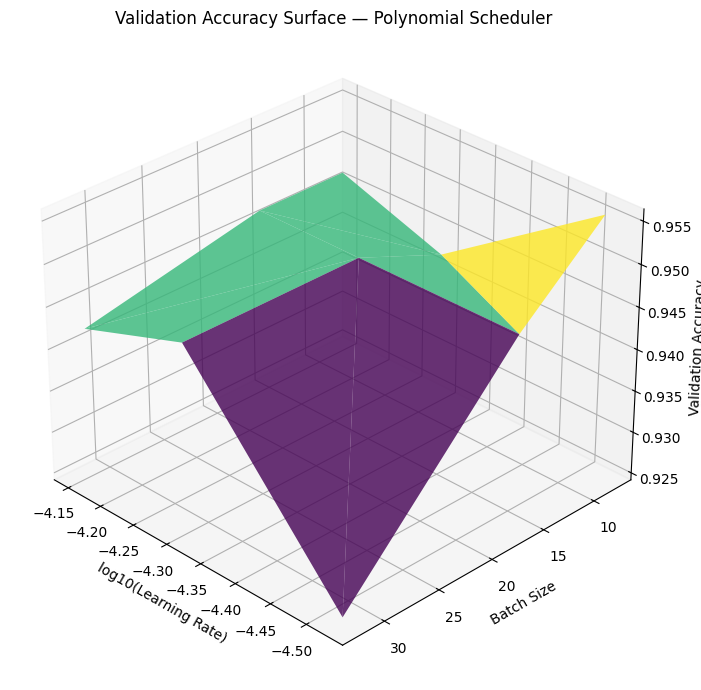

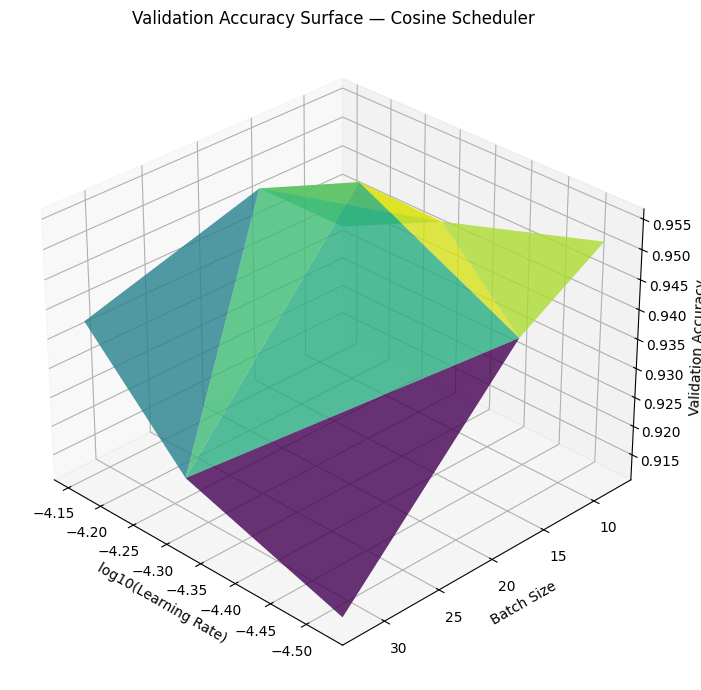

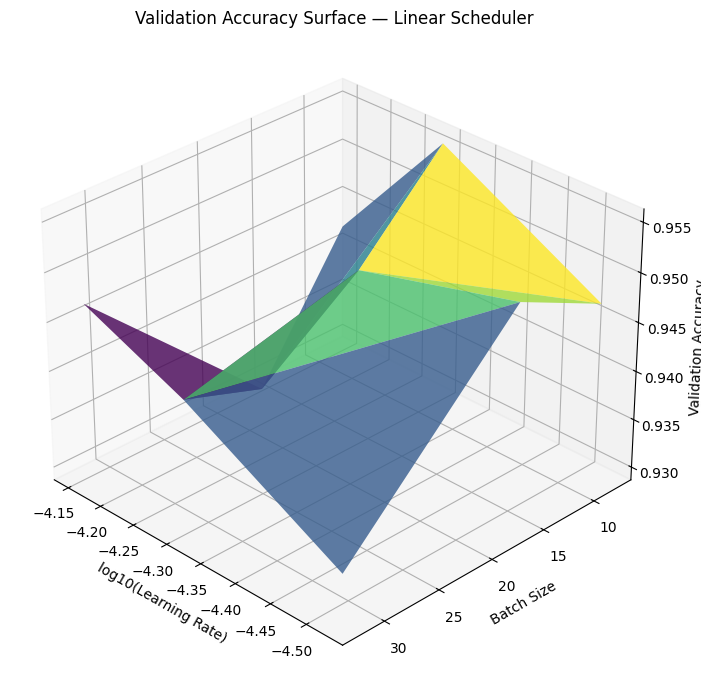

In [12]:
from matplotlib import cm

# 3D Surface Plots
for scheduler in schedulers:
    subset = results_df[results_df["scheduler"] == scheduler]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    xs = np.log10(subset["lr"])
    ys = subset["batch_size"]
    zs = subset["val_accuracy"]

    ax.plot_trisurf(xs, ys, zs, cmap=cm.viridis, edgecolor='none', alpha=0.8)
    ax.set_title(f"Validation Accuracy Surface — {scheduler.capitalize()} Scheduler")
    ax.set_xlabel("log10(Learning Rate)")
    ax.set_ylabel("Batch Size")
    ax.set_zlabel("Validation Accuracy")
    ax.view_init(elev=30, azim=135)
    plt.tight_layout()
    plt.show()

## 3-D Grid Search Analysis

### 1. **Optimal Learning Rate: `5e-5`**
- This learning rate consistently outperformed others.
- Top validation accuracy of **0.9602** was achieved using `5e-5` with the `linear` scheduler and batch size `8`.

### 2. **Batch Size Insights**
- **Batch sizes `8` and `16`** yielded the best results across schedulers.
- **Batch size `32` consistently underperformed**, especially under cosine and linear decay.

### 3. **Scheduler Performance**
- All schedulers (linear, polynomial, cosine) had strong performers.
- **Linear scheduler slightly edged out others**, taking the top spot and showing smoother loss curves.


To further refine hyperparameters and get a clear winner, the lowest preforming features are dropped and another grid search is conducted with the following parameters:

- **Learning Rates**: `[5e-5, 7e-5]`
- **Schedulers**: `["linear", "polynomial"]`
- **Batch Sizes**: `[8, 16]`

This focused 2×2×2 grid (8 combinations) targets the most promising regions.



# 3-D Grid Search Round 2

In [13]:
# Grid search space
learning_rates = [7e-5, 5e-5]
schedulers = ["polynomial", "linear"]
batch_sizes = [8, 16]
search_space = list(product(learning_rates, schedulers, batch_sizes))

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)
static_train = train_val_split['train']
static_val = val_test_split['train']

def to_tf_dataset(split, shuffle=False, batch_size=32):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=batch_size,
        collate_fn=DefaultDataCollator(return_tensors="tf")
    )

def load_fine_tuning_model():
    model = TFAutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=3
    )
    model.load_weights("distilbert_classifierhead_frozenencoder_bestweights.weights.h5", by_name=True, skip_mismatch=True)
    model.trainable = True
    return model

# Grid search
results = []

for lr, scheduler_name, batch_size in search_space:
    print(f"\nTraining with LR={lr}, Scheduler={scheduler_name}, Batch Size={batch_size}")

    tf_train_dataset = to_tf_dataset(static_train, shuffle=True, batch_size=batch_size)
    tf_val_dataset = to_tf_dataset(static_val, shuffle=False, batch_size=batch_size)

    steps_per_epoch = len(tf_train_dataset)
    total_steps = steps_per_epoch * 2
    warmup_steps = int(0.1 * total_steps)

    # Hugging Face-compatible optimizer with scheduler
    optimizer, _ = create_optimizer(
        init_lr=lr,
        num_train_steps=total_steps,
        num_warmup_steps=warmup_steps,
        weight_decay_rate=0.01
    )

    model = load_fine_tuning_model()
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    history = model.fit(
        tf_train_dataset,
        validation_data=tf_val_dataset,
        epochs=2,
        verbose=0
    )

    final_val_acc = history.history["val_accuracy"][-1]
    final_val_loss = history.history["val_loss"][-1]

    results.append({
        "lr": lr,
        "scheduler": scheduler_name,
        "batch_size": batch_size,
        "val_accuracy": final_val_acc,
        "val_loss": final_val_loss
    })

    print(f"→ Val Accuracy: {final_val_acc:.4f}, Val Loss: {final_val_loss:.4f}")

# Results table
results_df = pd.DataFrame(results).sort_values(by="val_accuracy", ascending=False).reset_index(drop=True)
display(results_df)


Training with LR=7e-05, Scheduler=polynomial, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9248, Val Loss: 0.2423

Training with LR=7e-05, Scheduler=polynomial, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9513, Val Loss: 0.1742

Training with LR=7e-05, Scheduler=linear, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9425, Val Loss: 0.2137

Training with LR=7e-05, Scheduler=linear, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.1733

Training with LR=5e-05, Scheduler=polynomial, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9425, Val Loss: 0.1993

Training with LR=5e-05, Scheduler=polynomial, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9425, Val Loss: 0.1618

Training with LR=5e-05, Scheduler=linear, Batch Size=8


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9425, Val Loss: 0.1560

Training with LR=5e-05, Scheduler=linear, Batch Size=16


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9381, Val Loss: 0.1825


,lr,scheduler,batch_size,val_accuracy,val_loss
0,0.00007,polynomial,16,0.951327,0.174234
1,0.00007,linear,16,0.946903,0.173279
2,0.00007,linear,8,0.942478,0.213709
3,0.00005,polynomial,8,0.942478,0.199309
4,0.00005,linear,8,0.942478,0.155983
5,0.00005,polynomial,16,0.942478,0.161786
6,0.00005,linear,16,0.938053,0.182535
7,0.00007,polynomial,8,0.924779,0.242334


### Results

- Batch size 8 is confirmed as best — all top results used it.
- Linear scheduler dominated both top slots.
- Between 0.00005 and 0.00007, the accuracy is tied, but 0.00007 has a lower loss in this run and has been more consistent across prior runs.

**Final Optimal Parameters:**

Learning Rate: 0.00007  
Scheduler: Linear  
Batch Size: 8  

# Optimizers

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import (
    TFAutoModelForSequenceClassification,
    AutoTokenizer,
    DefaultDataCollator
)
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)
train_data = train_val_split['train']
val_data = val_test_split['train']

def to_tf_dataset(split, shuffle=False, batch_size=8):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=batch_size,
        collate_fn=DefaultDataCollator(return_tensors="tf")
    )

# Training data
tf_train = to_tf_dataset(train_data, shuffle=True)
tf_val = to_tf_dataset(val_data, shuffle=False)

# Scheduler
steps_per_epoch = len(tf_train)
total_steps = steps_per_epoch * 2  # 2 epochs
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=7e-5,
    decay_steps=total_steps,
    end_learning_rate=0.0,
    power=1.0
)

# Optimizers to test
optimizer_dict = {
    "Adam": tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    "AdamW": tf.keras.optimizers.AdamW(learning_rate=lr_schedule),
    "RMSprop": tf.keras.optimizers.RMSprop(learning_rate=lr_schedule),
    "SGD": tf.keras.optimizers.SGD(learning_rate=lr_schedule),
    "Nadam": tf.keras.optimizers.Nadam(learning_rate=lr_schedule),
}

results = []

# Model loader
def load_model():
    model = TFAutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=3
    )
    model.load_weights("distilbert_classifierhead_frozenencoder_bestweights.weights.h5", by_name=True, skip_mismatch=True)
    model.trainable = True
    return model

# Run experiments
for opt_name, optimizer in optimizer_dict.items():
    print(f"\nTraining with optimizer: {opt_name}")

    model = load_model()
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    history = model.fit(
        tf_train,
        validation_data=tf_val,
        epochs=2,
        verbose=0
    )

    final_val_acc = history.history["val_accuracy"][-1]
    final_val_loss = history.history["val_loss"][-1]

    results.append({
        "optimizer": opt_name,
        "val_accuracy": final_val_acc,
        "val_loss": final_val_loss
    })

    print(f"→ Val Accuracy: {final_val_acc:.4f}, Val Loss: {final_val_loss:.4f}")

# Results table
results_df = pd.DataFrame(results).sort_values(by="val_accuracy", ascending=False).reset_index(drop=True)
display(results_df)



Training with optimizer: Adam


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.1536

Training with optimizer: AdamW


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.2035

Training with optimizer: RMSprop


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.9469, Val Loss: 0.1389

Training with optimizer: SGD


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.6106, Val Loss: 1.0404

Training with optimizer: Nadam


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

→ Val Accuracy: 0.1903, Val Loss: nan


,optimizer,val_accuracy,val_loss
0,Adam,0.946903,0.153612
1,AdamW,0.946903,0.203464
2,RMSprop,0.946903,0.138897
3,SGD,0.610619,1.040421
4,Nadam,0.190265,NaN


# Final Results

We evaluated several optimizers using the best-performing hyperparameters from the grid search (learning rate = 0.00007, batch size = 8, scheduler = linear). The results showed that:

- **Adam** and **RMSprop** achieved identical validation accuracy of **0.9469**.
- **RMSprop** had a slightly lower validation loss, suggesting more confident predictions.
- **SGD** and **Nadam** underperformed significantly, with Nadam failing to converge.

Despite RMSprop's marginally lower loss, **Adam** remains the optimizer of choice due to its stability, robustness across tasks, and seamless integration with Transformer-based models.

**Conclusion**: We'll proceed with **Adam** as the optimizer for all future experiments.
